# Naïve Bayes Classification
- *Author*: Juan Cabanela
- *Start Date*: November 29, 2021

### Requirements

Requires the following python libraries:
- pandas
- numpy
- scikit-learn (sklearn)

This notebook should only be executed using the cleaned version of the FakeNewsCorpus that has been "chunked" into smaller portions with the context preserved. This data should be in the `fullcontext_dir` directory defined at the end of the first block of code (defaulted value is `./FakeNewsCorpus/fullcontextnews_chunked/`).

This code is the working Naive Bayes classifier (two of them actually) for this group project.

### History
- **November 29, 2021**: First version of this code based on the `NBClassifier_testbed` notebook, but with several of my test runs of a classifier removed.  Testing expanding the number of words in the TF-IDF vectorizer to see if that changes the performance.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import pathlib
import pickle
import time
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, naive_bayes, metrics
from sklearn.model_selection import cross_validate, StratifiedKFold

##
## Custom functions
##

def full_testing_report(test_Y, predicted_Y, classifier_label):
    # Get the training classification report and confusion matrix
    report = metrics.classification_report(test_Y, predicted_Y,
                                        target_names=['Positive', 'Negative'])
    conf_matrix = metrics.confusion_matrix(test_Y, predicted_Y)

    if (DEBUG):
        print(f"confusion matrix for {classifier_label}:")
        print(conf_matrix)

    tn, fp, fn, tp = conf_matrix.ravel()
    conf_matrix_report(tn, fp, fn, tp, classifier_label)
    print(f"\nclassification report for {classifier_label}:")
    print(report)


# Print out report based on confusion matrix
def conf_matrix_report(tn, fp, fn, tp, classifier_label):
    # Do some manual computations
    p = tp + fn  # Positives
    n = fp + tn  # Negatives

    print(f"Classification Summary for {classifier_label}:")
    print(f"\tClassed as positive: {p:07d}")
    print(f"\tClassed as negative: {n:07d}\n")

    print(f"Confusion Matrix for {classifier_label}:")
    print(" Predicted    Positive      Negative")
    print("Actual")
    print(f"Positive    {tp:07d}(TP)   {fn:07d}(FN)   {p:07d}(P)")
    print(f"Negative    {fp:07d}(FP)   {tn:07d}(TN)   {n:07d}(N)\n")

    accuracy = (tp + tn) / (p + n)
    err_rate = (fp + fn) / (p + n)
    precision = tp / (tp + fp)
    recall = tp / p
    specificity = tn / n
    Fscore = (2 * precision * recall) / (precision + recall)

    print(f"  Accuracy (TP+TN)/P+N =\t{accuracy:0.5f}")
    print(f"Error Rate (FP+FN)/P+N =\t{err_rate:0.5f}")
    print(f"  Precision TP/(TP+FP) =\t{precision:0.5f}")
    print(f"           Recall TP/P =\t{recall:0.5f}")
    print(f"      Specificity TN/N =\t{specificity:0.5f}")
    print(f"               F-Score =\t{Fscore:0.5f}")


# kfold_summary turns the scores directionary created by cross_validate and
# turns it into human readable information.
# Note: This assumes 'estimator' is returned and uses that as a blank column.
def kfold_summary(scores, verbose=False):
    keys = sorted(scores.keys())
    nkeys = len(keys)

    # Print all the data for each run of the k-fold cross-validation
    if (verbose):
        for key in keys:
                if (key != "estimator"):
                        print(f"{key:15s} ", end="")
                else:
                        print(f"                ", end="")
        print("")

        if (DEBUG):
            for i in range(len(scores[keys[0]])):
                for key in keys:
                    if (key != "estimator"):
                        print(f"{scores[key][i]:15.3f} ", end="")
                    else:
                        print(f"{' ':10s}", end="")
                print("")

    # Dictionaries for statistics
    avgs = {}
    stdev = {}

    for key in keys:
        if (key != "estimator"):
            newkey = "avg_"+key
            avgs[newkey] = np.average(scores[key])
            if (verbose):
                print(f"{avgs[newkey]:15.3f} ", end="")
        else:
            if (verbose):
                print(f"{'Mean:':8s}", end="")
    if (verbose):
        print("")

    for key in keys:
        if (key != "estimator"):
            newkey = "stdev_"+key
            stdev[newkey] = np.std(scores[key])
            if (verbose):
                print(f"{stdev[newkey]:15.3f} ", end="")
        else:
            if (verbose):
                print(f"{'Std Dev:':8s}", end="")
    if (verbose):
        print("")

    return(avgs, stdev)


##
## Define constants
##
DEBUG = False

# Directory containing chunked data
data_dir = "../FakeNewsCorpus/"
fullcontext_dir = f"{data_dir}fullcontextnews_chunked/"
var_dir = "../Variables/"


## Loading the chunked data files

Read the files which have already been cleaned but had their context preserved [so no stop words were removed and punctuation is intact] and build a single dataframe containing the entire cleaned dataset. It takes about 50sec to load all the data into memory. The full dataset now occupies about 5.5GB of memory unpacked.

In [2]:
# Set up path to chunked CSV files
chunked_path = pathlib.Path(fullcontext_dir)

# Set up path to pickle file
pickle_file = f"{data_dir}fullcontext_df.p"
pickle_path = pathlib.Path(pickle_file)

# If pickle file exists, avoid reprocessing and just load it
if (pickle_path.is_file()):
    print(f"Loading previously pickled fullcontext_df (about {pickle_path.stat().st_size/1024**3:0.2f} GB)")
    fullcontext_df = pickle.load( open( pickle_file, "rb" ) )  # Reading pickles should be cross-platform

    # Get all the categories as a list
    rawcategories = np.array(fullcontext_df["1st_type"].unique()).astype('str')
    categories = rawcategories[rawcategories != 'nan'].tolist()
else:
    # Create master dataframe
    fullcontext_df = pd.DataFrame(columns=["title", "content", "1st_type" , "2nd_type", "3rd_type"])

    # Iterate through chunked csv files alphabetically
    n_tot = 0

    print("Loading records: ")
    for i, fname in enumerate(sorted(chunked_path.iterdir())):
        if ".csv" in str(fname):
            print(f"   {fname.name}: ", end="")
            chunked_df = pd.read_csv(fname, dtype={'domain': str, 'title': str, 'content': str, '1st_type': str, '2nd_type': str, '3rd_type': str})

            n_tot = n_tot + chunked_df.shape[0]
            fullcontext_df = fullcontext_df.append(chunked_df, ignore_index=True)
            print(f" {chunked_df.shape[0]} entries loaded.")


    # Get all the categories as a list
    rawcategories = np.array(fullcontext_df["1st_type"].unique()).astype('str')
    categories = rawcategories[rawcategories != 'nan'].tolist()

    # Collect 1st_type counts
    summary = fullcontext_df["1st_type"].value_counts()

    # Add a column for each category, flagging the entry as an example, collect stats
    for cat in categories:
        fullcontext_df[cat] = (fullcontext_df['1st_type'] == cat) | (fullcontext_df['2nd_type']  == cat) | (fullcontext_df['3rd_type']  == cat)
        print(f"- '{cat}': {len(fullcontext_df[fullcontext_df[cat]])} total articles (only {summary[cat]} as 1st_type).")

    # Pickle the data
    print(f"Creating {pickle_file} ... ")
    pickle.dump( fullcontext_df, open(pickle_file, "wb" ) )

print(f"\n{fullcontext_df.shape[0]} entries loaded into fullcontext_df which is occupying {fullcontext_df.memory_usage(deep=True).sum()/1024**3:0.3f} GB of memory.")
print(f"- Classifications included for {len(categories)} classes of journalistic practices.")

Loading previously pickled fullcontext_df (about 4.66 GB)

7687298 entries loaded into fullcontext_df which is occupying 10.760 GB of memory.
- Classifications included for 11 classes of journalistic practices.


## Apply TF-IDF vectorizer

Here we implement a TD-IDF vectorizer taken from Scikit-Learn and then save the resulting sparse array into a pickle file.  The idea is it takes about 13 minutes to run this, no need to needlessly run this. However, if you change any hyperparameters (aka function parameters) for the TF-IDF vectorizer, you should wipe out the corresponding pickle file and rerun the following.

- a 10,000 feature TF-IDF vectorizer took about 13 minutes to build.
- a 100,000 feature TF-IDF vectorizer took about 22 minutes to build.

In [3]:
# Trying to get TF-IDF vectorizer to work on the fullcontext_df
words2keep = 100000

# Create variables directory if needed
try:
    pathlib.Path(var_dir).mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"Variable storage directory {var_dir} is already there")
else:
    print(f"Variable storage directory {var_dir} was created")

# Set up path to pickle file
vectorizer_pickle_file = f"{var_dir}fullcontext_vectorizer_{words2keep:06d}.p"
tokenized_pickle_file = f"{var_dir}fullcontext_tokenized_{words2keep:06d}.p"
vectorizer_pickle_path = pathlib.Path(vectorizer_pickle_file)
tokenized_pickle_path = pathlib.Path(tokenized_pickle_file)
# If pickle files exist, avoid reprocessing and just load them
if (vectorizer_pickle_path.is_file() & tokenized_pickle_path.is_file() ):
    print(f"Loading previously pickled vectorizer (about {vectorizer_pickle_path.stat().st_size/1024**3:0.2f} GB)")
    vectorizer = pickle.load( open( vectorizer_pickle_file, "rb" ) )
    print(f"Loading previously pickled tokenized_corpus (about {tokenized_pickle_path.stat().st_size/1024**3:0.2f} GB)")
    tokenized_content = pickle.load( open( tokenized_pickle_file, "rb" ) )
else:
    print(f"Building new vectorizer and tokenized content using {words2keep} most important words...")

    # To prevent crashing out when processing, convert the Pandas column
    # of data into strings line by line.  Otherwise, when running the TfidfVectorizer
    # you will get the following error:
    # ValueError: np.nan is an invalid document, expected byte or unicode string.
    # unless I apply that string conversion to the column.
    corpus = fullcontext_df['content'].apply(lambda x: np.str_(x))

    # Now construct the vectorizer
    vectorizer = TfidfVectorizer(encoding='utf-8', decode_error='replace', strip_accents='ascii', stop_words='english', max_features=words2keep)

    # Apply the tokenizer (takes about 11-13 minutes to run)
    tokenized_content = vectorizer.fit_transform(corpus)

    # Pickle the data
    print(f"Creating {vectorizer_pickle_file} ... ")
    pickle.dump( vectorizer, open(vectorizer_pickle_file, "wb" ) )
    print(f"Creating {tokenized_pickle_file} ... ")
    pickle.dump( tokenized_content, open(tokenized_pickle_file, "wb" ) )

Variable storage directory ../Variables/ is already there
Loading previously pickled vectorizer (about 0.02 GB)
Loading previously pickled tokenized_corpus (about 4.37 GB)


In [4]:
if (DEBUG):
    # Report some stats on the TF-IDF runs
    print(f"get_feature_names_out: {vectorizer.get_feature_names_out()}")
    # Show vocabulary
    print(f"vocabulary_: {vectorizer.vocabulary_}")
    # Show additional stop words
    print(f"stop_words_: {vectorizer.stop_words_}")

# Implementation of Naïve Bayes Classifier (Binary Version)

I am following some of the approach laid out in [this article from the Medium website](https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34) for attemptin to set up a Naïve Bayes textual classifier. This only looks at the 'reliable' flag.

In [5]:
# This sets up the Multinomial Naive Bayes classifier, one of the styles of classifiers typically
# used with text classification problems.
#  https://scikit-learn.org/stable/modules/naive_bayes.html

jour_prac = 'reliable'  # Classify articles as reliable or not

# Set up path to pickle file
clfnet_pickle_file = f"{var_dir}NBbinary_{jour_prac}.p"
clfnet_pickle_path = pathlib.Path(clfnet_pickle_file)

# If pickle file exists, avoid reprocessing and just load them
if (clfnet_pickle_path.is_file()):
    print(f"Loading previously-built binary classifier (about {clfnet_pickle_path.stat().st_size/1024**2:0.2f} MB)")
    classifier_info = pickle.load( open( clfnet_pickle_file, "rb" ) )
else:
    # Track time for building of all the classifiers
    network_start_time = time.perf_counter()
    print(f"Constructing ComplementNB binary classifier: ")

    # Create blank dictionary
    classifier_info = {}

    # Break up ENTIRE dataset into training and testing data (reserving 20% for testing).
    # Use the tokenized content so we can avoid having to re-tokenize the data each new pass through.
    print(f" - Constructing, training and testing Naïve Bayes classifier on test data on '{jour_prac}' class... ")
    Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y = model_selection.train_test_split(tokenized_content,fullcontext_df[jour_prac],test_size=0.2)

    # Implement Multinomial Naïve Bayes training for this dataset (including timing of the training)
    # Problem, currently returns all 'false' in fitting.
    start_time = time.perf_counter()
    clf = naive_bayes.ComplementNB()
    clf.fit(Train_X_Tfidf, Train_Y)
    end_time = time.perf_counter()

    # Save the trained classifier
    classifier_info["clf"] = clf

    if (DEBUG):
        print(f"clf.classes_: {clf.classes_}")
        print(f"clf.feature_count_: {clf.feature_count_}")

    # predict the labels on validation dataset
    predictions_NB = clf.predict(Test_X_Tfidf)
    print(f"   - {end_time - start_time:0.2f} seconds to fit and test Naïve Bayes classifier on '{jour_prac}' class.")

    # Report on the testing
    if (DEBUG):
        full_testing_report(Test_Y, predictions_NB, jour_prac)

    # Get confusion matrix on the model
    tn, fp, fn, tp = metrics.confusion_matrix(Test_Y, predictions_NB).ravel()
    conf_mat = {"TN": tn, "FP": fp, "FN": fn, "TP": tp}

    # Implement k-fold cross-validation to get a better handle on classfier accuracy.
    # Report on the various 'scoring' statistics.  cv=5 indicates we are doing k=5 cross-validations.
    start_time = time.perf_counter()
    scores = cross_validate(clf, tokenized_content,fullcontext_df[jour_prac], scoring={'accuracy','precision','recall', 'f1'},
                            cv=5, return_estimator=True)
    end_time = time.perf_counter()
    print(f"   - {end_time - start_time:0.2f} seconds to perform k-fold cross-validation on '{jour_prac}' class")

    # Provide kfold_summary
    (avgs, stdev) = kfold_summary(scores)

    # Merge one record for this classifier in a dictionary
    classifier_info = dict(chain.from_iterable(d.items() for d in (classifier_info, conf_mat, avgs, stdev)))

    # End of network time
    network_end_time = time.perf_counter()
    print(f"Entire binary classifier took {network_end_time - network_start_time:0.2f} seconds to build.")

    # Pickle the data
    print(f"Creating {clfnet_pickle_file} ... ")
    pickle.dump(classifier_info, open(clfnet_pickle_file, "wb" ) )




Loading previously-built binary classifier (about 3.82 MB)


In [6]:
# Construct table of statistics describing classifier network
print(f"{'category':10s}\t{'N_pos':7s}\t{'N_neg':7s}\t{'accuracy':12s}\t{'precision':12s}\t{'recall':12s}\t{'f1':12s}")
# Format statistics
actual_pos = classifier_info['TP']+classifier_info['FN']
actual_neg = classifier_info['TN']+classifier_info['FP']
this_accuracy = f"{classifier_info['avg_test_accuracy']:05.3f}({classifier_info['stdev_test_accuracy']:05.3f})"
this_precision = f"{classifier_info['avg_test_precision']:05.3f}({classifier_info['stdev_test_precision']:05.3f})"
this_recall = f"{classifier_info['avg_test_recall']:05.3f}({classifier_info['stdev_test_recall']:05.3f})"
this_f1 = f"{classifier_info['avg_test_f1']:05.3f}({classifier_info['stdev_test_f1']:05.3f})"

# Print statistics
print(f"{jour_prac:10s}\t{actual_pos:7d}\t{actual_neg:7d}\t{this_accuracy}\t{this_precision}\t{this_recall}\t{this_f1}")

category  	N_pos  	N_neg  	accuracy    	precision   	recall      	f1          
reliable  	 383645	1153815	0.809(0.037)	0.585(0.064)	0.824(0.156)	0.678(0.083)


# Implementation of Multiclass Naïve Bayes Classifier

In [8]:
# This sets up the ComplementNB Naive Bayes classifier, but trained to identify
# from all the classes at once instead of training on single classes (since it
# is possible single 'negative' cases which are a mix of known other classes
# could present a problem to the classifier).

# Nnumber of datasets to make up
sets = 5
n_cat = len(categories)  # Number of categories

# Create arrays to store all metrics data
conf_matrices = np.empty((sets, n_cat, n_cat))
accuracies = np.empty((sets))
recalls = np.empty((sets))
precisions = np.empty((sets))
f1s = np.empty((sets))
label_precisions = np.empty((sets, n_cat))
label_recalls = np.empty((sets, n_cat))
label_support = np.empty((sets, n_cat))
label_f1s = np.empty((sets, n_cat))  #  Must use beta=1 to weight precision and recall equally to get f1

# Set up path to pickle file
multiclassclf_pickle_file = f"{var_dir}NB_Multiclass.p"
multiclassclf_pickle_path = pathlib.Path(multiclassclf_pickle_file)
multiclassstats_pickle_file = f"{var_dir}NB_Multiclass_stats.p"
multiclassstats_pickle_path = pathlib.Path(multiclassstats_pickle_file)

# If pickle file exists, avoid reprocessing and just load them
if (multiclassclf_pickle_path.is_file() & multiclassstats_pickle_path.is_file() ):
    print(f"Loading previously-built Multiclass ComplementNB classifier network (about {clfnet_pickle_path.stat().st_size/1024**2:0.2f} MB)")
    clf = pickle.load( open( multiclassclf_pickle_path, "rb" ) )
    [conf_matrices, accuracies, recalls, precisions, f1s, labels, label_precisions, label_recalls, label_f1s, label_support] = pickle.load( open( multiclassstats_pickle_path, "rb" ) )
else:
    # Track time for building of all the classifiers
    network_start_time = time.perf_counter()
    print(f"Constructing ComplementNB multiclass classifier: ")

    # Create blank dictionary
    this_entry = {}

    # Turn classes into numerical labels (trying to see if this 'fixes' problem with confusion matrix dumping
    # out as single row)
    le = LabelEncoder()
    le.fit(categories)
    labels = le.classes_
    labeled_data = le.transform(fullcontext_df['1st_type'])

    # The scikit-learn documentation notes that "Some classification problems can exhibit a large imbalance in
    # the distribution of the target classes: for instance there could be several times more negative samples
    # than positive samples. In such cases it is recommended to use stratified sampling".  This would be useful
    # if I was checking multiple classes, not useful for Naïve Bayes.  Keeping this here as notes in case someone
    # is grabbing testing/training data for multi-class classifier.

    # Create 5 statified datasets for K-fold cross-validation
    # Use the tokenized content so we can avoid having to re-tokenize the data each new pass through.
    print(f" - Executing StratifiedKFold to create {sets} testing/training datasets ... ", end="")
    spliter = model_selection.StratifiedKFold(n_splits=sets)
    print(f"DONE!")
    for fold, (train_index, test_index) in enumerate(spliter.split(tokenized_content, labeled_data)):
        print(f"   - Starting on fold {fold+1} of {sets}.")
        strat_train_set = fullcontext_df.loc[train_index]
        strat_test_set = fullcontext_df.loc[test_index]
        Train_X_Tfidf, Test_X_Tfidf = tokenized_content[train_index], tokenized_content[test_index]
        Train_Y, Test_Y = labeled_data[train_index], labeled_data[test_index]

        # Train this classifier
        start_time = time.perf_counter()
        clf = naive_bayes.ComplementNB()
        clf.fit(Train_X_Tfidf, Train_Y)

        # predict the labels on validation dataset
        predictions_NB = clf.predict(Test_X_Tfidf)
        end_time = time.perf_counter()
        print(f"   - {end_time - start_time:0.2f} seconds to fit and test multiclass ComplementNB classifier on fold {fold+1} of {sets}.")

        # Track the various metrices for each fold
        start_time = time.perf_counter()
        numlabels = [item for item in range(le.classes_.shape[0])]
        conf_matrices[fold] = metrics.confusion_matrix(Test_Y, predictions_NB, labels=numlabels, normalize='true').ravel().reshape((le.classes_.shape[0], le.classes_.shape[0]))
        # Statistics per label
        label_precisions[fold], label_recalls[fold], label_f1s[fold], label_support[fold] = metrics.precision_recall_fscore_support(Test_Y, predictions_NB, labels=numlabels, beta=1.0)
        # Macro average means "Calculate metrics for each label, and find their unweighted mean.
        # This does not take label imbalance into account."
        accuracies[fold] = metrics.accuracy_score(Test_Y, predictions_NB)
        recalls[fold] = metrics.recall_score(Test_Y, predictions_NB, average='macro')
        precisions[fold] = metrics.precision_score(Test_Y, predictions_NB, average='macro')
        f1s[fold] = metrics.f1_score(Test_Y, predictions_NB, average='macro')
        stats = [conf_matrices, accuracies, recalls, precisions, f1s, labels, label_precisions, label_recalls, label_f1s, label_support]
        end_time = time.perf_counter()
        print(f"   - {end_time - start_time:0.2f} seconds to gather metrics on fold {fold+1} of {sets}.")

    print(f"Creating {multiclassclf_pickle_file} ... ")
    pickle.dump(clf, open(multiclassclf_pickle_file, "wb" ) )
    print(f"Creating {multiclassstats_pickle_file} ... ")
    pickle.dump(stats, open(multiclassstats_pickle_file, "wb" ) )

Loading previously-built Multiclass ComplementNB classifier network (about 3.82 MB)


Summary ComplementNB Classification Report of 5 K-Folds
                 precision        recall      f1-score         support
bias          0.548(0.062)  0.569(0.052)  0.557(0.051)   218306.6(0.5)
clickbait     0.516(0.193)  0.283(0.102)  0.363(0.130)    47335.4(0.5)
conspiracy    0.624(0.071)  0.533(0.077)  0.573(0.068)   166982.8(0.4)
fake          0.567(0.065)  0.519(0.025)  0.540(0.035)   175606.6(0.5)
hate          0.505(0.077)  0.200(0.057)  0.285(0.070)    25602.0(0.0)
junksci       0.454(0.037)  0.616(0.075)  0.521(0.047)    28509.2(0.4)
political     0.671(0.025)  0.540(0.170)  0.584(0.100)   330868.8(0.4)
reliable      0.595(0.065)  0.819(0.141)  0.685(0.084)   377892.4(0.5)
rumor         0.673(0.070)  0.800(0.046)  0.728(0.050)    95990.6(0.5)
satire        0.617(0.236)  0.183(0.116)  0.275(0.159)    22304.2(0.4)
unreliable    0.596(0.148)  0.275(0.245)  0.349(0.236)    48061.0(0.0)

accuracy                                  0.600(0.046)  1537459.6(0.5)
macro         0.579(

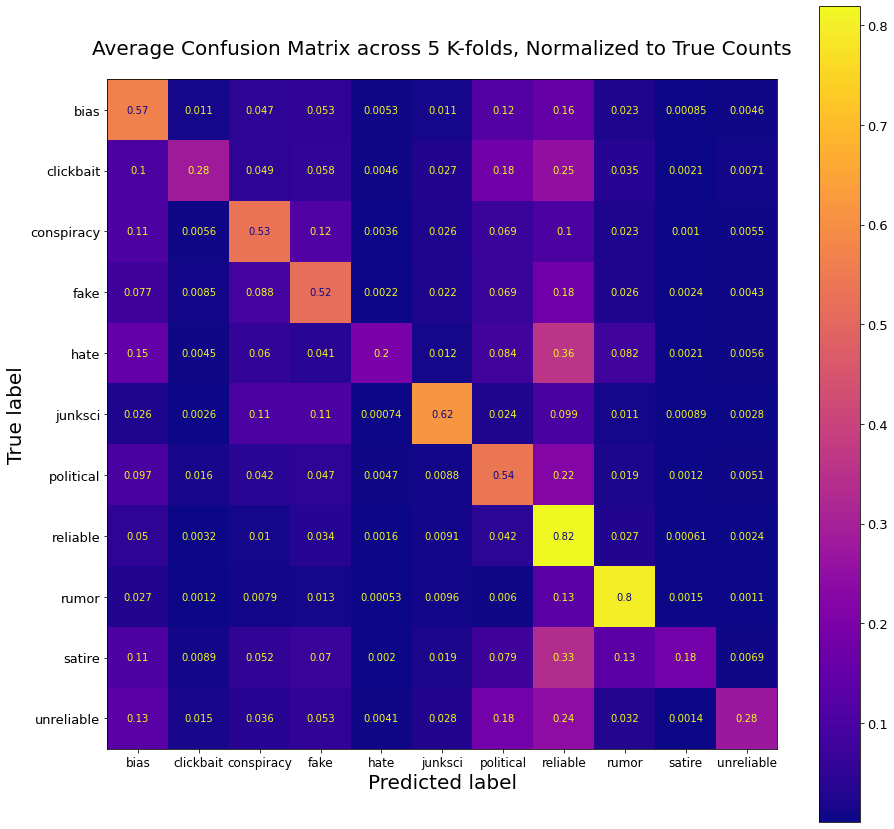

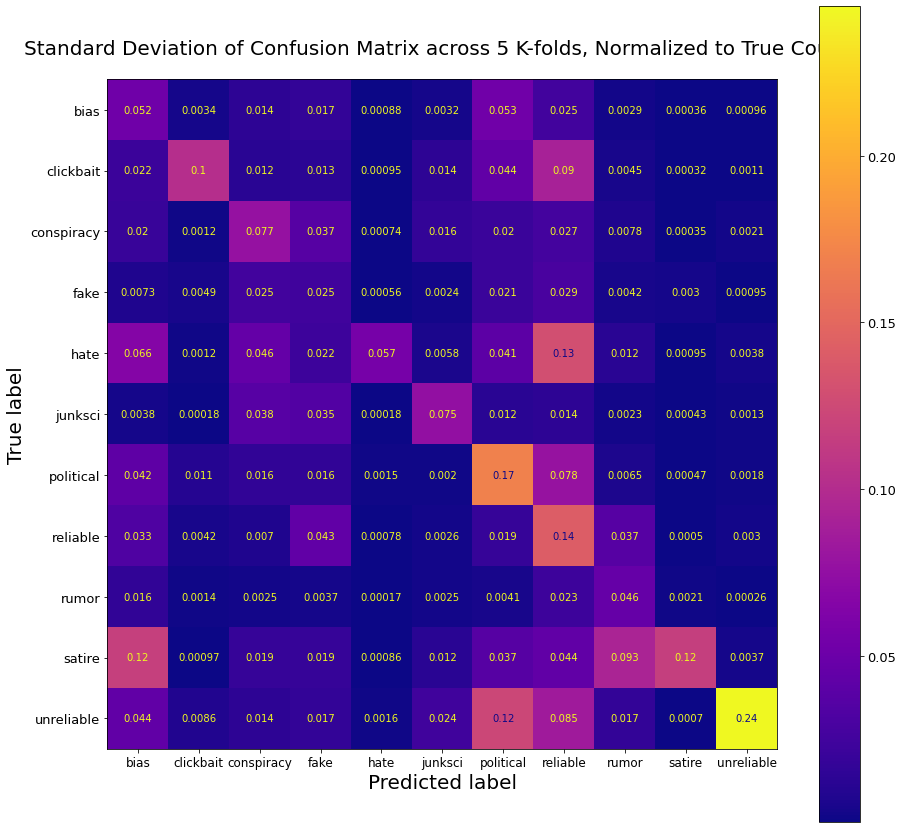

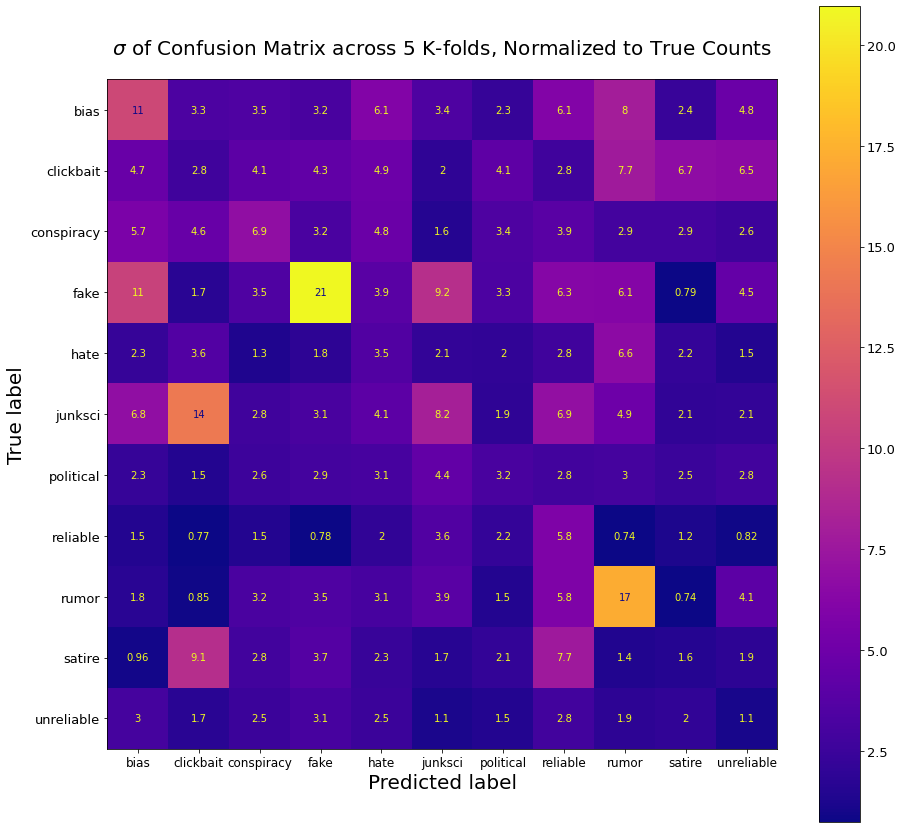

In [11]:
# Display classification report (for last single classifier)
# print(metrics.classification_report(Test_Y, predictions_NB, target_names=le.classes_))

# Try to model classification report but with stats from K-Fold cross-validation
print(f"Summary ComplementNB Classification Report of {sets} K-Folds")
print(f"{' ':12}  {'precision':>12}  {'recall':>12}  {'f1-score':>12}  {'support':>14}")

# Get averages and standard deviations for labels
label_avgprecision = np.average(label_precisions, axis=0)
label_avgrecall = np.average(label_recalls, axis=0)
label_avgf1 = np.average(label_f1s, axis=0)
label_avgsupport = np.average(label_support, axis=0)
label_stdprecision = np.std(label_precisions, axis=0)
label_stdrecall = np.std(label_recalls, axis=0)
label_stdf1 = np.std(label_f1s, axis=0)
label_stdsupport = np.std(label_support, axis=0)
total_support = np.sum(label_support,axis=1)
for i, label in enumerate(labels):
    precision_str = f"{label_avgprecision[i]:04.3f}({label_stdprecision[i]:04.3f})"
    recall_str = f"{label_avgrecall[i]:04.3f}({label_stdrecall[i]:04.3f})"
    f1_str = f"{label_avgf1[i]:04.3f}({label_stdf1[i]:04.3f})"
    support_str = f"{label_avgsupport[i]:6.1f}({label_stdsupport[i]:.1f})"
    print(f"{label:12}  {precision_str:12}  {recall_str:12}  {f1_str:12}  {support_str:>14}")
print("")

# Get global averages and standard deviations
avg_totsupport = np.average(total_support, axis=0)
std_totsupport = np.std(total_support, axis=0)
avg_accuracy = np.average(accuracies, axis=0)
std_accuracy = np.std(accuracies, axis=0)
avg_macrorecall = np.average(recalls, axis=0)
std_macrorecall = np.std(recalls, axis=0)
avg_macroprec = np.average(precisions, axis=0)
std_macroprec = np.std(precisions, axis=0)
avg_macrof1 = np.average(f1s, axis=0)
std_macrof1 = np.std(f1s, axis=0)

totsupport_str = f"{avg_totsupport:6.1f}({std_totsupport:.1f})"
accuracy_str = f"{avg_accuracy:04.3f}({std_accuracy:04.3f})"
macro_recall_str = f"{avg_macrorecall:04.3f}({std_macrorecall:04.3f})"
macro_prec_str = f"{avg_macroprec:04.3f}({std_macroprec:04.3f})"
macro_f1_str = f"{avg_macrof1:04.3f}({std_macrof1:04.3f})"

print(f"{'accuracy':12}  {' ':12}  {' ':12}  {accuracy_str:12}  {totsupport_str:>14}")
print(f"{'macro':12}  {macro_prec_str:12}  {macro_recall_str:12}  {macro_f1_str:12}  {totsupport_str:>14}")

# Adjust font sizes (copied from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot)
size=20
params = {'legend.fontsize': 'large',
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.60,
          'ytick.labelsize': size*0.65,
          'axes.titlepad': 25}
plt.rcParams.update(params)

# Display average confusion matrix
avg_conf_matrix = np.average(conf_matrices,axis=0)
std_conf_matrix = np.std(conf_matrices,axis=0)
sigma_conf_matrix = avg_conf_matrix/std_conf_matrix  # Computes sigma of how certain average (how different from zero)

fig, ax = plt.subplots(figsize=(15, 15))
disp = metrics.ConfusionMatrixDisplay(avg_conf_matrix, display_labels=labels)
disp.plot(cmap='plasma', ax=ax)
disp.ax_.set_title(f"Average Confusion Matrix across {sets} K-folds, Normalized to True Counts")
plt.savefig("Final_MulticlassCM_average.png", facecolor="w")  # Save PNG with white background

fig, ax = plt.subplots(figsize=(15, 15))
disp = metrics.ConfusionMatrixDisplay(std_conf_matrix, display_labels=labels)
disp.plot(cmap='plasma', ax=ax)
disp.ax_.set_title(f"Standard Deviation of Confusion Matrix across {sets} K-folds, Normalized to True Counts")
plt.savefig("Final_MulticlassCM_stdev.png", facecolor="w")

fig, ax = plt.subplots(figsize=(15, 15))
disp = metrics.ConfusionMatrixDisplay(sigma_conf_matrix, display_labels=labels)
disp.plot(cmap='plasma', ax=ax)
disp.ax_.set_title(f"$\sigma$ of Confusion Matrix across {sets} K-folds, Normalized to True Counts")
plt.savefig("Final_MulticlassCM_sigma.png", facecolor="w")